In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import seaborn as sns
import pickle

In [2]:
df_scaled = pd.read_csv('df_scaled.csv')

In [3]:
features = ['danceability', 'energy', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'year']

In [4]:
# Dividimos nuestros datos para entrenamiento y test
X = df_scaled[features]
y = df_scaled['track_popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Análisis de profundidad y alpha

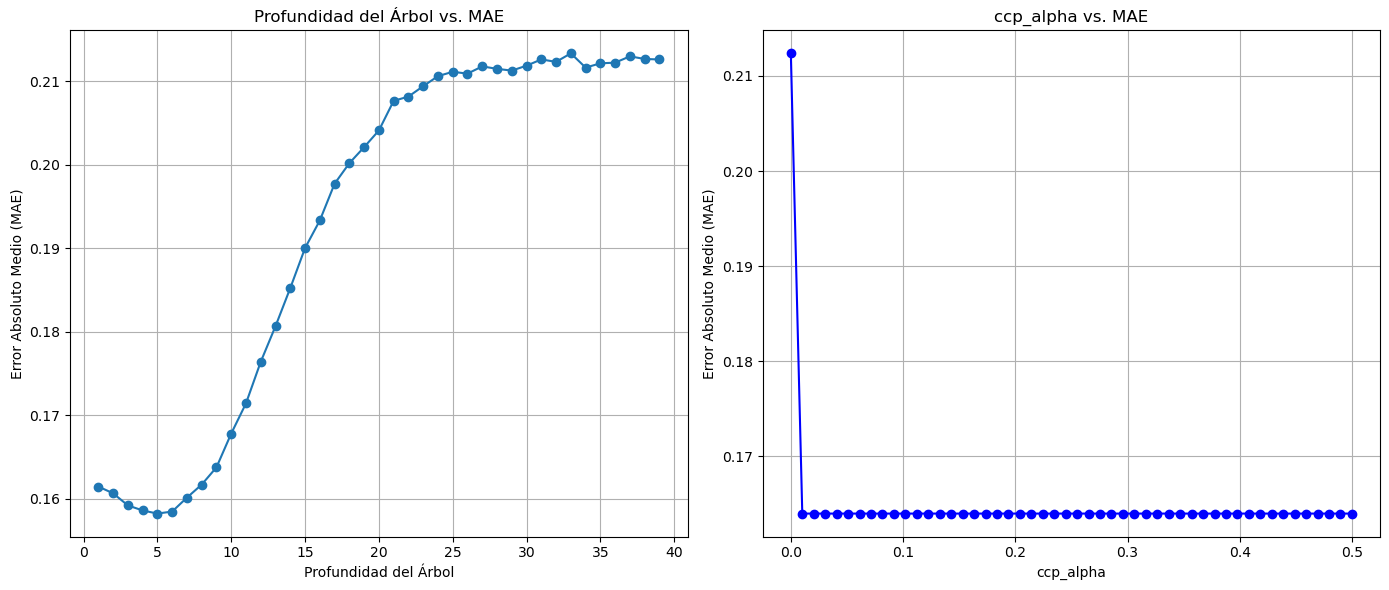

In [5]:
# Vemos como la profundidad y el valor de alpha afectan el MAE

depths = range(1, 40)
mae_scores_depth = []

for depth in depths:
    dt_regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(dt_regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_scores_depth.append(-scores.mean())

ccp_alphas = np.linspace(0, 0.5, 50)

mae_scores_alpha = []

for ccp_alpha in ccp_alphas:
    dt_regressor_alpha = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    scores_alpha = cross_val_score(dt_regressor_alpha, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_scores_alpha.append(-scores_alpha.mean())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(depths, mae_scores_depth, marker='o')
plt.title('Profundidad del Árbol vs. MAE')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ccp_alphas, mae_scores_alpha, marker='o', color='b')
plt.title('ccp_alpha vs. MAE')
plt.xlabel('ccp_alpha')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.grid(True)

plt.tight_layout()
plt.show()

Vemos que el MAE no cambia ante valores de alpha mayores a 0

#### Entrenamos un árbol sin podar y evaluamos el rendimiento.

In [6]:
# Creamos el primer árbol sin podar
dt = DecisionTreeRegressor(criterion='squared_error', splitter='best',
                                   max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                   random_state=42)

dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [7]:
# Vemos el tamaño del árbol (número de nodos y profundidad)
tree_depth = dt.get_depth()
tree_n_leaves = dt.get_n_leaves()

print(f"Profundidad del árbol: {tree_depth}")
print(f"Número de hojas: {tree_n_leaves}")

Profundidad del árbol: 40
Número de hojas: 14619


In [8]:
# Entrenamos y evaluamos el modelo
y_pred = dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 0.21035871225949515
MSE: 0.06991270342972192
RMSE: 0.26441010462862785
MAPE: 12305296349316.744
R2: -0.7991414894007323


#### Realizamos una búsqueda del mejor valor de ccp_alpha usando GridSearchCV

In [9]:
dt_regressor = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                                   max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                   random_state=42)

# Definimos el rango de valores para ccp_alpha
param_grid = {
    'ccp_alpha': np.linspace(0, 0.5, 500)
}

# Configuramos GridSearchCV con validación cruzada (cv=5)
grid_search = GridSearchCV(dt_regressor, param_grid, scoring='neg_mean_squared_error', cv=5)

In [10]:
# Entrenamos con el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos el mejor valor de ccp_alpha y el mejor modelo entrenado
best_alpha = grid_search.best_params_['ccp_alpha']
best_model = grid_search.best_estimator_

print(f"Mejor valor de ccp_alpha: {best_alpha:.4f}")

Mejor valor de ccp_alpha: 0.0010


In [11]:
# Exportación del modelo
if best_model is not None:
    model_save_path = 'models/decisionTreeRegressor.pkl'
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo: {best_model}")
    print(f"Guardado como '{model_save_path}'")

Mejor modelo: DecisionTreeRegressor(ccp_alpha=np.float64(0.001002004008016032),
                      random_state=42)
Guardado como 'models/decisionTreeRegressor.pkl'


In [12]:
# Vemos el tamaño del árbol (número de nodos y profundidad)
tree_depth = best_model.get_depth()
tree_n_leaves = best_model.get_n_leaves()

print(f"Profundidad del árbol: {tree_depth}")
print(f"Número de hojas: {tree_n_leaves}")

Profundidad del árbol: 1
Número de hojas: 2


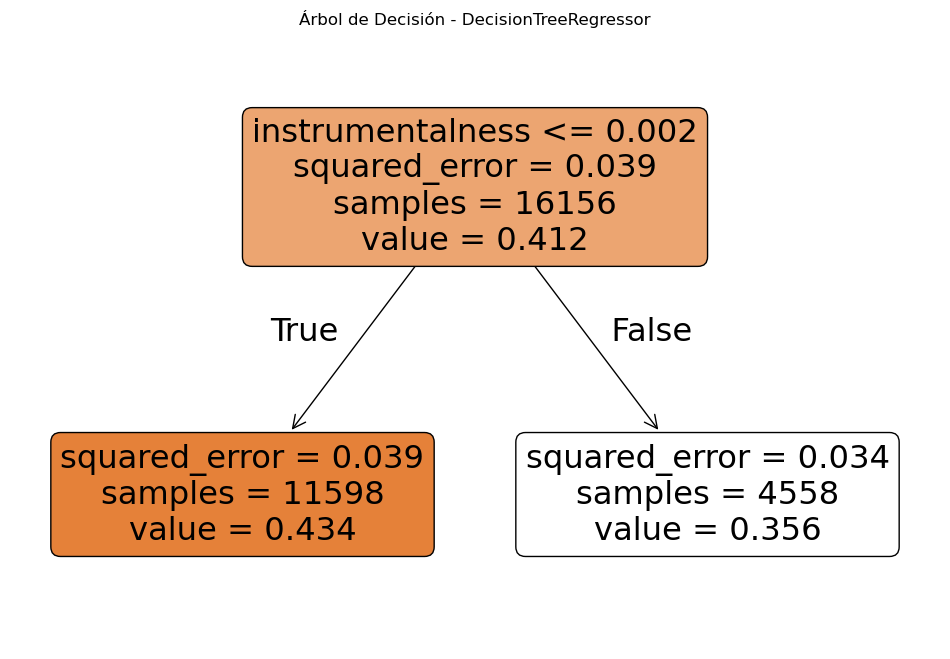

In [13]:
#Gráficamos el árbol
plt.close('all')
plt.figure(figsize=(12, 8))
plot_tree(best_model, filled=True, feature_names=features, rounded=True)
plt.title("Árbol de Decisión - DecisionTreeRegressor")
plt.show()

#### Entrenamos y evaluamos el mejor modelo

In [14]:
# Entrenamos y evaluamos el mejor modelo
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 0.161376400682576
MSE: 0.03781521693118744
RMSE: 0.19446135073887416
MAPE: 11063081380254.426
R2: 0.02685889153208265


Vemos que las métricas en general mejoraron ligeramente en relación al árbol inicial, pero es importante destacar que se redujo considerablemente el árbol.